# 2-Correlation Matrix for S&P500 Data
## Mohammad Ghoraishi - 99100788
---
Code was written as a group with (Salarvandian - 400100254) and (Mohammad Ghoraishi - 99100788)


In [1]:
using MAT, Plots, Statistics, CSV, DataFrames, Dates #Importing packages for statistics, plotting and importing .mat files

### Define used Functions
---

To replicate what was done in the article, we need to do two things.
1) Calculate the return rate of the given S&P500 data matrix.
2) Normalize the timeseries with a window size of $k=13$.
3) Segment the matrix into two month long periods.
4) Calculate the correlation matrix for all segments and plot the heatmaps
#### Algorithms
1) To calculate the return rate matrix, we simply apply the formula below on all timeseries of the matrix <br>
and save the result in a new matrix (return_rate_matrix())<br>
$
r(t) = \frac{S(t + \Delta t) - S(t)}{S(t)}
$
2) To normalize the return rate matrix we again use the formula given in the article and save the results <br>
   in a new matrix. (normalize_matrix())<br>
   $\tilde{r}(t) = \frac{r(t) - \langle r(t) \rangle _n}{\sqrt{\langle r^2(t) \rangle _n - \langle r(t) \rangle ^2 _n}}$
   It's good to note that if for whatever reason, the price doesn't change over the span of the window, the denominator <br>
   of this formula will be zero which will cause a NAN output which will ruin the entire timeseries. to remedy this, we <br>
   can calculate the denominator first, and if it results in a zero, we will replace $\tilde{r}(t)$ with zero.
3) Segmenting our data to two month long sections is rather easy, we just need to keep a number of rows and all the columns of the <br>
   initial matrix. To do this we use the Date.csv file and after removing the first 12 datapoints (because of normalization), we add <br>
   8 weeks to the date (using Dates.jl package) and find the first datapoint which comes after this new date. Now we have the start and <br>
   end indexes that correspond to a two month window.
4) For each two month data segment, we calculate the correlation matrix using the cor() function from the Statistice.jl package. This function <br>
   can take a matrix and calculate the correlation matrix of all the columns which is what we want. Then we save all these matrices and plot the <br>
   heatmaps.

In [ ]:
#Function that takes a matrix and calculates the return rate (as described in the article) for each column of said matrix.
function return_rate_matrix(mat::Matrix)
    height, width = size(mat)
    new_mat = zeros(height-1, width) #The resulting matrix has one less row than the original
    #Main loop iterates over the matrix and calculates the return rate, then writes the result directly to the new matrix
    for i in 1:height-1 
        for j in 1:width
            new_mat[i,j] = (mat[i+1,j] - mat[i,j])/mat[i,j]
        end
    end
    return new_mat
end

#Function that tales a matrix and normalizes (as described in the article) each column with a window of 'k' which we use k=13
function normalize_matrix(mat::Matrix, k::Int)
    height, width = size(mat)
    new_mat = zeros(height-(k-1), width) #The resulting matrix has k-1 less row than the original
    #Main loop iterates over the matrix and normalizes each column, then writes the result directly to the new matrix
    for i in 1:height-(k-1)
        for j in 1:width
            temp = mat[i:i+k-1, j] #temporary array that holds the latest k values of column j including the current value
            #Sometimes if price doesn't change over a few days (ex. company becomes untradeable for a couple weeks), the
            #denominator of our normalization formula will become zero resulting in a NAN value which ruins our other calculations.
            #To remedy this situation, we calculate the denominator first, then if it is zero, we replace the normalized value with 
            #zero since the change in price is zero.
            denom = sqrt(mean(temp.^2) - mean(temp)^2) 
            if (denom == 0 || isnan(denom)) #test if denom is zero or NAN
                new_mat[i,j] = 0
            else
                new_mat[i,j] = (mat[i+k-1,j] - mean(temp))/denom
            end
        end
    end
    return new_mat
end

### Openning the .mat data, formatting and correlation matrix calculation
---

In [ ]:
file = matopen("data/sxp/price/All.mat") #We use the MAT.jl package to extract the matrix from the file
a = read(file)
matrix = a["A"]
#Calculating the return rate for the matrix and normalizing it for k=13
matrix = return_rate_matrix(matrix)
matrix = normalize_matrix(matrix,13)
#The correlation matrix is computed using the cor() function from the Statistics.jl package. 
#This function takes the matrix, then computes the Pearson correlation coefficient for every pair of rows.
#This results in the correlation matrix which we want.
correlation_matrix = cor(matrix)


### Example all-time correlation matrix
---
Since there were no data labels in the .mat file, I speculated the market segment labels and they may be false.

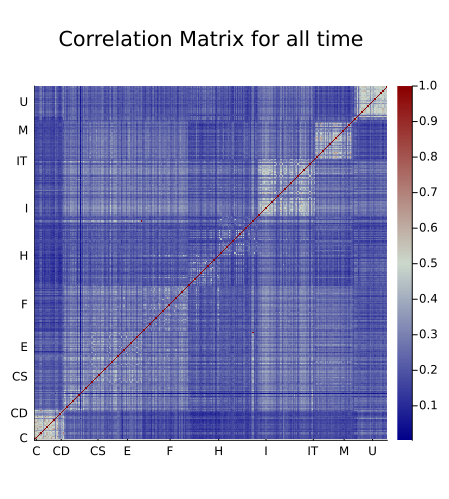

In [5]:
heatmap(correlation_matrix, aspectratio = 1, c = :bluesreds, size = (450,500), title = "\nCorrelation Matrix for all time",
        xticks = ([2; 23; 54; 79; 115; 156; 196; 236; 262; 286], ["C"; "CD"; "CS"; "E"; "F"; "H"; "I"; "IT"; "M"; "U"]),
        yticks = ([2; 23; 54; 79; 115; 156; 196; 236; 262; 286], ["C"; "CD"; "CS"; "E"; "F"; "H"; "I"; "IT"; "M"; "U"]))

Result Analysis: We can see markets within a market segment generally correlate more strongly. <br>
While there are a few hotspots where markets have a correlation coefficient of around 0.7, most <br>
other markets do not correlate as much.

### Calculating matrices every two months and drawing the heatmaps
---

In [36]:
#Calculating all correlation matrices
Date_array = CSV.read("data/sxp/price/Date.csv", DataFrame)[!,1][12:end] #Openning the dates data and removing the first 12 entries to account for normalization
index = 1
matrix_array = [] #array to save all matrices
df_dates = DataFrame(start_date = Date_array[index], end_date = Date_array[index+42]) #dataframe to keep track of dates for each matrix
while (Date_array[index] + Week(8) <= Date_array[end]) #We continue the loop until there aren't 8 weeks worth of continous data
    end_index = findfirst(x -> (x >= Date_array[index] + Week(8)), Date_array) #Calculating the first index where 8 weeks has passed
    mat = cor(matrix[index:end_index, :]) #Calculating the correlation matrix in the correct timeframe
    #Saving the results in arrays
    push!(matrix_array, mat)
    push!(df_dates, [Date_array[index] Date_array[end_index]])
    index = end_index + 1
end

In [43]:
#Plotting and saving the heatmaps
for num in 1:length(matrix_array) 
        start = df_dates.start_date[num]
        ends = df_dates.end_date[num]
        plt = heatmap(matrix_array[num], aspectratio = 1, c = :bluesreds, size = (450,500), title = "\n$start - $ends",
                xticks = ([2; 23; 54; 79; 115; 156; 196; 236; 262; 286], ["C"; "CD"; "CS"; "E"; "F"; "H"; "I"; "IT"; "M"; "U"]),
                yticks = ([2; 23; 54; 79; 115; 156; 196; 236; 262; 286], ["C"; "CD"; "CS"; "E"; "F"; "H"; "I"; "IT"; "M"; "U"]))
        savefig(plt, "Exercise2-matrices/"*"$num.pdf")
end

In [ ]:
#We can also see a gif of the matrix evolution
anim = @animate for num in 1:length(matrix_array) #Animation loop
    start = df_dates.start_date[num]
        ends = df_dates.end_date[num]
        heatmap(matrix_array[num], aspectratio = 1, c = :bluesreds, size = (450,500), title = "\n$start - $ends",
            xticks = ([2; 23; 54; 79; 115; 156; 196; 236; 262; 286], ["C"; "CD"; "CS"; "E"; "F"; "H"; "I"; "IT"; "M"; "U"]),
            yticks = ([2; 23; 54; 79; 115; 156; 196; 236; 262; 286], ["C"; "CD"; "CS"; "E"; "F"; "H"; "I"; "IT"; "M"; "U"]))
end
gif(anim, "matrix_animation.gif", fps = 12)

Result Analysis: The figures are available in the Exercise2-matrices.rar file. Going through the <br>
images, we can see the different patterns that were described in the article. There are also instances <br>
were most markets become severely correlated which usually indicate a market crash (ex. 2008). A gif <br>
is also included in this report named as matrix_animation.gif. In the gif we can see the evolution <br>
of the patterns throughout our time window.

### Saving the Matrtix data to a file (The file is a .jld file which can be openned using the JLD python package)
---
*This file is not included in the archived file sent since it is more than 80Mb*

In [50]:
#saving the Matrices in a file and the dates in another file
using JLD, CSVFiles
CSV.write("Exercise2-matrices/date_start_end.csv", df_dates)
save("Exercise2-matrices/matrices.jld", "Mat", matrix_array)

### Unusual data points
---
We found that there are two pairs of time-series data that are exactly the same resulting in two $C_{ij} = 1$ instances. <br>
These markets surprisingly completely have the same price data which is really unusual. We can see the numbers below:

In [79]:
#Finding all C=1 points except the ones on the diagonal
a = findall(x->(x == 1), cor(matrix))
b = []
for i in a
    if i[1] != i[2]
        push!(b, i)
    end
end
b

4-element Vector{Any}:
 CartesianIndex(185, 91)
 CartesianIndex(91, 185)
 CartesianIndex(295, 294)
 CartesianIndex(294, 295)

In [51]:
#We see that the difference between the two time-series is zero
file = matopen("data/sxp/price/All.mat")
a = read(file)
mat = a["A"]
mat[:,295] .- mat[:,294]

4789-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0